### This notebook generate the line benefits from the operational cost

In [67]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [68]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150',
                                                                         150: 'st151', 151: 'st152', 152: 'st153', 153: 'st154', 154: 'st155',
                                                                         155: 'st156', 156: 'st157', 157: 'st158', 158: 'st159', 159: 'st160'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.index.name = None
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [69]:
#%% Setting up the path a cases
DirName  = os.getcwd()

CaseName_Base     = '9n'
CaseName_ByStages = CaseName_Base+'_ByStages'

CSV_name =  'oT_Data_Profiles_' + CaseName_Base

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [70]:
df_1 = pd.read_csv(_path_0+'/2.Par'+'/'+CSV_name+'.csv', index_col=0)
diff_df_1 = df_1

In [71]:
#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [72]:
diff_df_1.head()

,Unnamed: 1,Unnamed: 2,Demand,Solar,Wind,Hydro
2030,sc01,01-01 00:00:00+01:00,976.000000,0.0,157.075000,0
2030,sc01,01-01 01:00:00+01:00,934.491895,0.0,144.705600,0
2030,sc01,01-01 02:00:00+01:00,896.076257,0.0,134.218275,0
2030,sc01,01-01 03:00:00+01:00,869.357209,0.0,128.766400,0
2030,sc01,01-01 04:00:00+01:00,848.582196,0.0,120.892500,0


In [73]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [74]:
diff_df_1.head()

,Unnamed: 1,Unnamed: 2,Demand,Solar,Wind,Hydro
LoadLevel,,,,,,
01-01 00:00:00+01:00,sc01,01-01 00:00:00+01:00,976.000000,0.0,157.075000,0
01-01 01:00:00+01:00,sc01,01-01 01:00:00+01:00,934.491895,0.0,144.705600,0
01-01 02:00:00+01:00,sc01,01-01 02:00:00+01:00,896.076257,0.0,134.218275,0
01-01 03:00:00+01:00,sc01,01-01 03:00:00+01:00,869.357209,0.0,128.766400,0
01-01 04:00:00+01:00,sc01,01-01 04:00:00+01:00,848.582196,0.0,120.892500,0


In [75]:
# Selecting the columns demand, wind, solar, hydro
diff_df_1 = diff_df_1[['Demand', 'Wind', 'Solar', 'Hydro']]

In [76]:
ddf_1 = diff_df_1.stack()

In [77]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [78]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [79]:
ddf_1.head()

Value
LoadLevel            Execution            
01-01 00:00:00+01:00 Demand     976.000000
                     Wind       157.075000
                     Solar        0.000000
                     Hydro        0.000000
01-01 01:00:00+01:00 Demand     934.491895

In [80]:
ddf_1 = ddf_1.reset_index()

In [81]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [82]:
# ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

In [83]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [84]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
34939,12-30 22:00:00+01:00,Hydro,0.000000,1900-12-30 22:00:00
34940,12-30 23:00:00+01:00,Demand,952.950245,1900-12-30 23:00:00
34941,12-30 23:00:00+01:00,Wind,235.870875,1900-12-30 23:00:00
34942,12-30 23:00:00+01:00,Solar,0.000000,1900-12-30 23:00:00
34943,12-30 23:00:00+01:00,Hydro,0.000000,1900-12-30 23:00:00


#### Getting day of year and month

In [85]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [86]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,Demand,976.000000,1900-01-01 00:00:00,0,1,1,1
1,01-01 00:00:00+01:00,Wind,157.075000,1900-01-01 00:00:00,0,1,1,1
2,01-01 00:00:00+01:00,Solar,0.000000,1900-01-01 00:00:00,0,1,1,1
3,01-01 00:00:00+01:00,Hydro,0.000000,1900-01-01 00:00:00,0,1,1,1
4,01-01 01:00:00+01:00,Demand,934.491895,1900-01-01 01:00:00,1,1,1,1


#### Generation new ID considering each line, and hour

In [87]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [88]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
34939,12-30 22:00:00+01:00,Hydro,0.000000,1900-12-30 22:00:00,22,364,52,12,Hydro_22
34940,12-30 23:00:00+01:00,Demand,952.950245,1900-12-30 23:00:00,23,364,52,12,Demand_23
34941,12-30 23:00:00+01:00,Wind,235.870875,1900-12-30 23:00:00,23,364,52,12,Wind_23
34942,12-30 23:00:00+01:00,Solar,0.000000,1900-12-30 23:00:00,23,364,52,12,Solar_23
34943,12-30 23:00:00+01:00,Hydro,0.000000,1900-12-30 23:00:00,23,364,52,12,Hydro_23


In [89]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [90]:
table.tail()

Variable   Demand_0    Demand_1   Demand_10   Demand_11   Demand_12  \
Month Day                                                             
12    360     976.0  934.491895  958.674753  984.679103  981.955527   
      361     976.0  934.491895  958.674753  984.679103  981.955527   
      362     976.0  934.491895  958.674753  984.679103  981.955527   
      363     976.0  934.491895  958.674753  984.679103  981.955527   
      364     976.0  934.491895  958.674753  984.679103  981.955527   

Variable    Demand_13   Demand_14    Demand_15    Demand_16    Demand_17  ...  \
Month Day                                                                 ...   
12    360  981.385054  997.079471  1042.721586  1097.274692  1127.363786  ...   
      361  981.385054  997.079471  1042.721586  1097.274692  1127.363786  ...   
      362  981.385054  997.079471  1042.721586  1097.274692  1127.363786  ...   
      363  981.385054  997.079471  1042.721586  1097.274692  1127.363786  ...   
      364  981.385054  997.079471  1042.721586  1097.274692  1127.363786  ...   

Variable      Wind_21     Wind_22     Wind_23      Wind_3      Wind_4  \
Month Day                                                               
12    360  171.648975  180.693050  185.785350  150.083925  152.852525   
      361  309.986025  317.334700  317.050875  164.621075  165.369225   
      362  293.897775  274.898125  248.761525  278.359125  266.523700   
      363  133.854825  136.079000  133.712625  195.756750  165.534025   
      364  267.108850  260.707475  235.870875  134.397200  135.797275   

Variable       Wind_5      Wind_6      Wind_7      Wind_8      Wind_9  
Month Day                                                              
12    360  153.129850  155.476225  164.744275  173.264825  174.684800  
      361  165.456000  167.968375  175.281300  190.685950  202.876025  
      362  261.233800  268.462950  270.024850  268.411275  269.423325  
      363  149.829475  145.412050  139.751150  133.087625  130.095200  
      364  137.219250  143.043275  147.232700  157.299650  167.486150  

[5 rows x 96 columns]

In [91]:
table = table.reset_index()

In [92]:
table = table.set_index(['Day'])

In [93]:
table.tail()

Variable,Month,Demand_0,Demand_1,Demand_10,Demand_11,Demand_12,Demand_13,Demand_14,Demand_15,Demand_16,...,Wind_21,Wind_22,Wind_23,Wind_3,Wind_4,Wind_5,Wind_6,Wind_7,Wind_8,Wind_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,976.0,934.491895,958.674753,984.679103,981.955527,981.385054,997.079471,1042.721586,1097.274692,...,171.648975,180.693050,185.785350,150.083925,152.852525,153.129850,155.476225,164.744275,173.264825,174.684800
361,12,976.0,934.491895,958.674753,984.679103,981.955527,981.385054,997.079471,1042.721586,1097.274692,...,309.986025,317.334700,317.050875,164.621075,165.369225,165.456000,167.968375,175.281300,190.685950,202.876025
362,12,976.0,934.491895,958.674753,984.679103,981.955527,981.385054,997.079471,1042.721586,1097.274692,...,293.897775,274.898125,248.761525,278.359125,266.523700,261.233800,268.462950,270.024850,268.411275,269.423325
363,12,976.0,934.491895,958.674753,984.679103,981.955527,981.385054,997.079471,1042.721586,1097.274692,...,133.854825,136.079000,133.712625,195.756750,165.534025,149.829475,145.412050,139.751150,133.087625,130.095200
364,12,976.0,934.491895,958.674753,984.679103,981.955527,981.385054,997.079471,1042.721586,1097.274692,...,267.108850,260.707475,235.870875,134.397200,135.797275,137.219250,143.043275,147.232700,157.299650,167.486150


#### Split data table into data X and class labels y

In [94]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [95]:
print(X)
print(y)

[[ 976.         934.4918953  958.6747532 ...   96.856325    87.694875
    73.9853   ]
 [ 923.4597191  901.5475338 1298.051694  ...   80.64685     75.846275
    69.022375 ]
 [1035.100407  1008.822176  1361.076364  ...   81.218875    82.57045
    87.144025 ]
 ...
 [ 976.         934.4918953  958.6747532 ...  270.02485    268.411275
   269.423325 ]
 [ 976.         934.4918953  958.6747532 ...  139.75115    133.087625
   130.0952   ]
 [ 976.         934.4918953  958.6747532 ...  147.2327     157.29965
   167.48615  ]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6  6  6  6

## PCA step by step

#### Standardizing of the data

In [96]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [97]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.10648475 -0.08093039  0.03874551 ...  0.          0.
   0.        ]
 [ 0.12645679 -0.09592497  0.052113   ...  0.          0.
   0.        ]
 [ 0.14643343 -0.12714914  0.07320167 ...  0.          0.
   0.        ]
 ...
 [ 0.14217184  0.14616453 -0.01156792 ...  0.          0.
   0.        ]
 [ 0.14448561  0.14240296 -0.01824277 ...  0.          0.
   0.        ]
 [ 0.14345043  0.1469736  -0.01921104 ...  0.          0.
   0.        ]]

Eigenvalues 
[3.10189983e+01 1.36782851e+01 1.07838481e+01 3.31981300e+00
 3.03114269e+00 2.19316231e+00 1.78373931e+00 1.58264106e+00
 1.41204376e+00 5.82348841e-01 4.29481272e-01 3.92848671e-01
 2.85734710e-01 2.67617662e-01 2.40075572e-01 2.18419935e-01
 1.84291514e-01 1.58370243e-01 1.13257786e-01 8.24092290e-02
 7.99662313e-02 6.89626123e-02 4.73380952e-02 4.29686868e-02
 4.14872229e-02 3.15102257e-02 1.80518399e-02 1.75228605e-02
 1.35847912e-02 1.18811332e-02 1.01230804e-02 7.95347136e-03
 6.12752838e-03 5.68899622e-03 5.0980677

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [98]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [99]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
31.018998264880636
13.678285133709224
10.78384814724298
3.319813002181248
3.0311426861140034
2.193162314739103
1.7837393122894216
1.5826410614951214
1.4120437611214476
0.5823488413056545
0.42948127178104434
0.39284867131123763
0.28573470966283815
0.26761766164940354
0.24007557150407957
0.21841993471413793
0.18429151448678394
0.15837024255326873
0.11325778609819429
0.08240922901085955
0.07996623132123784
0.06896261230480273
0.04733809519349017
0.04296868679252642
0.04148722294607126
0.031510225718460134
0.01805183994538379
0.017522860482991353
0.013584791220913448
0.011881133155187556
0.010123080361789268
0.007953471359702929
0.006127528376378894
0.005688996221954652
0.005098067727726124
0.004234032425915844
0.003794915418100646
0.003433317030688437
0.0028201313157148983
0.002349183223969466
0.0019408001293083504
0.0017448439319438648
0.0013397216954042438
0.0012516757498563318
0.0009754659043330273
0.0008800699061664494
0.0008007305129643497
0.000614163

### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [100]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [101]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

42.96358505094498 0
61.909012033303206 1
76.84543174274 2
81.44361596050477 3
85.64197064250791 4
88.67966111965342 5
91.15027074404696 6
93.34234455861781 7
95.2981286142004 8
96.10472442232751 9
96.69958744757369 10
97.2437116374622 11


Then

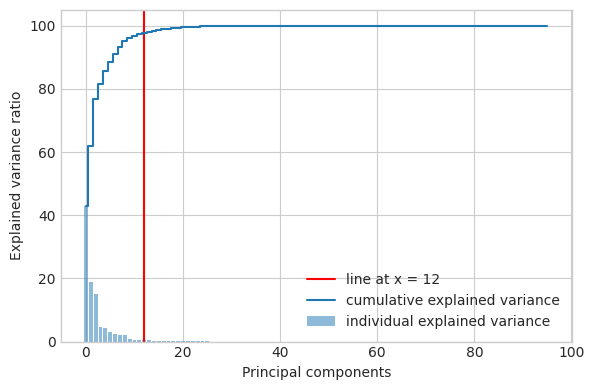

In [102]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [103]:
labels = np.unique(y, axis=0)

In [104]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

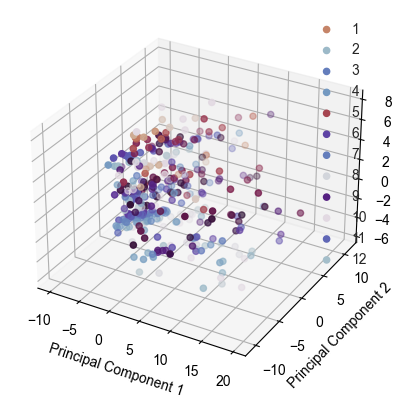

In [105]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

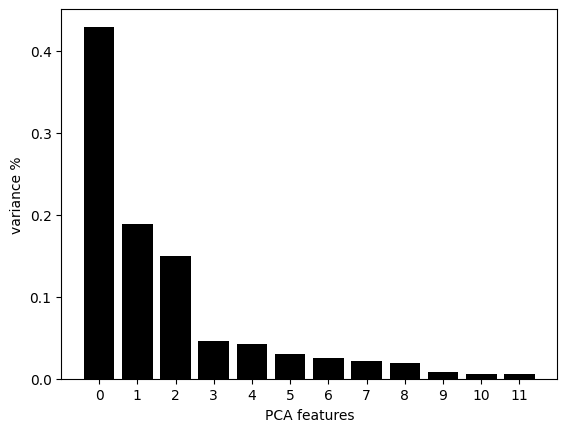

In [106]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [107]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [108]:
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-2.748505,-1.223716,2.451485,0.093744,1.401344,-1.470553,-0.852781,1.234298,0.703842,-0.312532,1.463738,-0.140748
1,1.554023,-7.808960,0.295562,-0.379829,1.061459,-0.642927,0.569786,-0.010734,-0.851008,1.401873,2.660489,2.286238
2,4.868957,-8.171339,-1.557694,-0.174315,-0.234456,1.148523,-0.887429,0.615056,-0.345486,0.778114,1.289999,0.785522
3,5.793757,-7.706675,-1.405737,0.645478,0.393559,-1.455271,-0.241571,0.457059,-0.082057,0.967175,0.941747,0.483833
4,2.762125,-10.403250,-0.243967,-0.429124,-0.495178,0.044695,-0.085328,0.406496,-0.451915,0.773423,0.194022,-0.012649


### Getting the optimal number of clusters

c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\erik_\miniconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\erik_\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for 

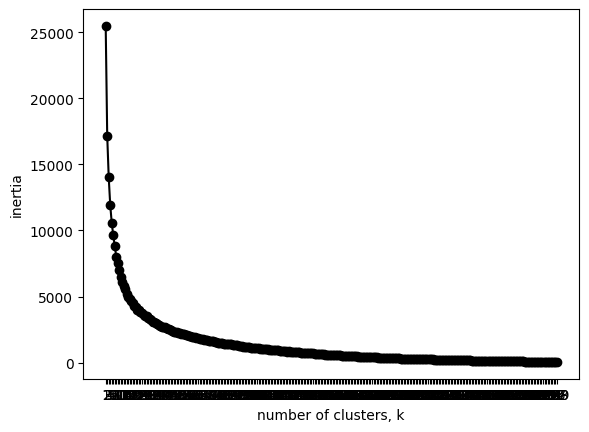

In [109]:
ks = range(1, max_cluster)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:i])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
plt.show()

In [110]:
opt_cluster = 0
for k in range(len(inertias)-1):
    diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
    if diff > 0.1:
        opt_cluster += 1
    else:
        break
print("Optimal number of clusters: ", opt_cluster)

Optimal number of clusters:  84


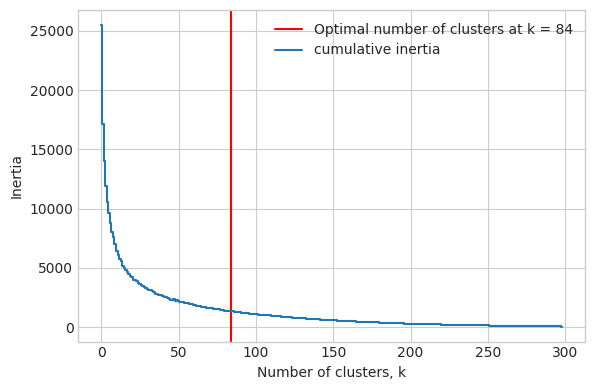

In [111]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
    # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            # label='individual explained variance')
    plt.step(range(len(inertias)), inertias, where='mid',
             label='cumulative inertia')
    
    plt.ylabel('Inertia')
    plt.xlabel('Number of clusters, k')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [112]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering


c:\Users\erik_\miniconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


End of the process...
